In [53]:
import numpy as np
from scipy.interpolate import splrep, splev
from scipy.stats import beta, norm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

Define hyperparameters

In [10]:
support = 1


### Define a damage function

In [49]:
y = [6000, 7000, 5500, 8000, 4000, 5500, 3500, 2500, 5500, 2000, 1000, 500, 1000]
n = len(y)
x = np.linspace(0, support, n)
tck = splrep(x, y)
f = lambda x: splev(x, tck, ext=1)

### Define a probability distribution

In [50]:
p_dist = beta(6, 2)
p = p_dist.pdf

### Calculate expected value of f(x) analytically

In [51]:
x_space = np.linspace(0, support, 1000)
f_space = f(x_space)
p_space = p(x_space / support)
product = f_space * p_space
mean = product.mean()
print(f"E[x] = {round(mean, 1)}")

E[x] = 2244.4


### Visual Summary

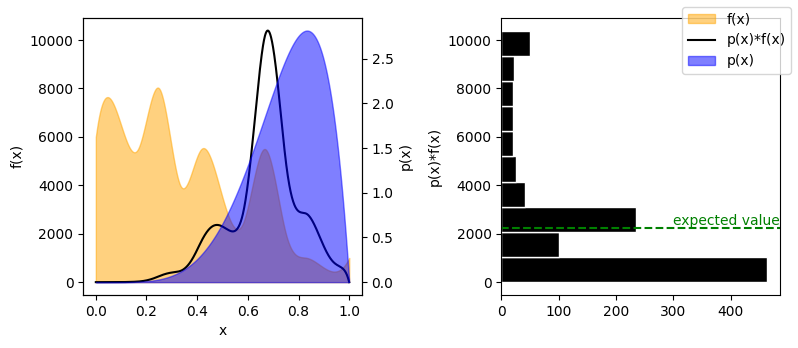

In [52]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 3.5))
axs[0].fill_between(x_space, 0, f_space, label="f(x)", color='orange', alpha=0.5)
axs[0].plot(x_space, product, c='k', label="p(x)*f(x)")
ax2 = axs[0].twinx()
ax2.fill_between(x_space, 0, p_space, label="p(x)", color='blue', alpha=0.5)
axs[0].set_xlabel("x")
axs[0].set_ylabel("f(x)")
ax2.set_ylabel("p(x)")
fig.legend()

axs[1].hist(product, orientation="horizontal", facecolor="k", edgecolor="w", label="p(x)*f(x)")
axs[1].axhline(mean, ls="dashed", c="green")
axs[1].text(axs[1].get_xlim()[1], mean, "expected value", va="bottom", ha="right", c="green")
axs[1].set_ylabel("p(x)*f(x)")

fig.tight_layout()

### Determine the mean via simulation

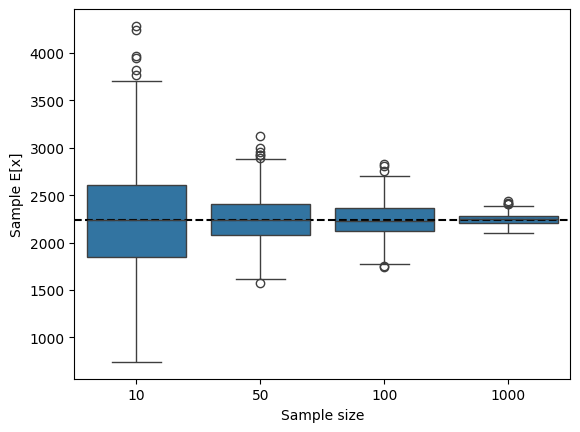

In [61]:
means = []
ns = []
epochs = 1000
for n in [10, 50, 100, 1000]:
    for i in range(epochs):
        tmp_x = p_dist.rvs(n) * support
        tmp_e = f(tmp_x).mean()
        means.append(tmp_e)
        ns.append(n)

df = pd.DataFrame({"Sample size": ns, "Sample E[x]": means})
fig, ax = plt.subplots()
sns.boxplot(df, x="Sample size", y="Sample E[x]", ax=ax)
ax.axhline(mean, c='k', ls="dashed")

### Implement importance sampling

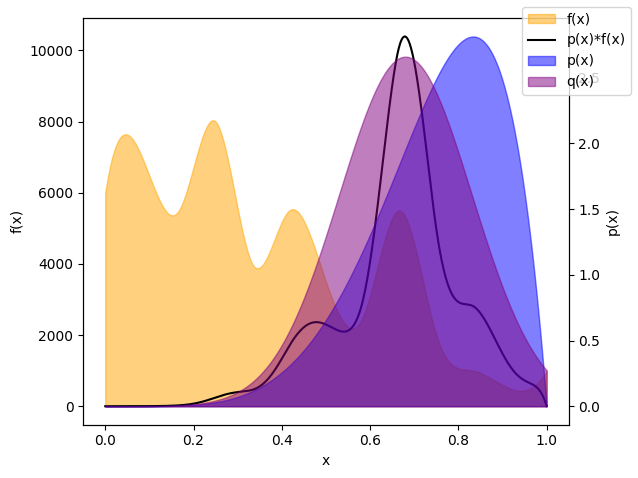

In [69]:
q_dist = norm(0.68, 0.15)
q = q_dist.pdf
q_space = q(x_space)

# Summary
fig, ax = plt.subplots()
ax.fill_between(x_space, 0, f_space, label="f(x)", color='orange', alpha=0.5)
ax.plot(x_space, product, c='k', label="p(x)*f(x)")
ax2 = ax.twinx()
ax2.fill_between(x_space, 0, p_space, label="p(x)", color='blue', alpha=0.5)
ax2.fill_between(x_space, 0, q_space, label="q(x)", color='purple', alpha=0.5)
ax.set_xlabel("x")
ax.set_ylabel("f(x)")
ax2.set_ylabel("p(x)")
fig.legend()

fig.tight_layout()

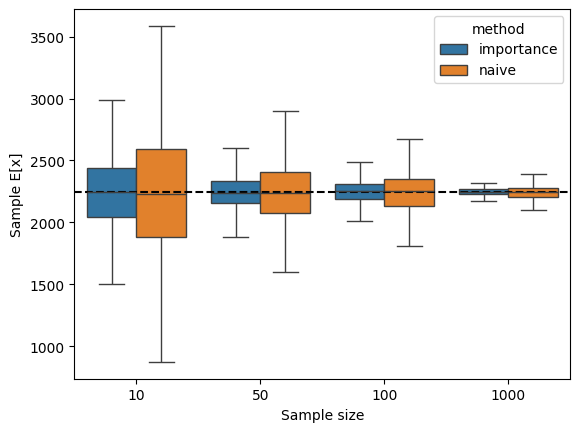

In [70]:
method = []
ns = []
means = []
epochs = 1000
for n in [10, 50, 100, 1000]:
    for i in range(epochs):
        tmp_x = q_dist.rvs(n) * support
        tmp_e = (f(tmp_x) * (p(tmp_x) / q(tmp_x))).mean()
        means.append(tmp_e)
        ns.append(n)
        method.append("importance")

        tmp_x = p_dist.rvs(n) * support
        tmp_e = f(tmp_x).mean()
        means.append(tmp_e)
        ns.append(n)
        method.append("naive")

df = pd.DataFrame({"Sample size": ns, "Sample E[x]": means, "method": method})
fig, ax = plt.subplots()
sns.boxplot(df, x="Sample size", y="Sample E[x]", hue="method", ax=ax, showfliers=False)
ax.axhline(mean, c='k', ls="dashed")

### Compare CDFs 

2243.4816569710906 2250.1886617526484


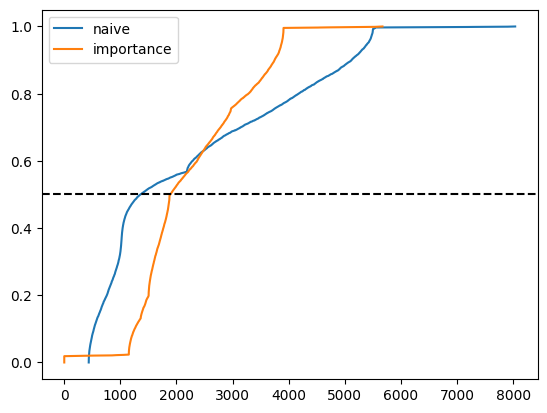

In [78]:
n = 10000
xs = p_dist.rvs(n)
naive_sample = f(xs)
xs = q_dist.rvs(n)
importance_sample = f(xs) * (p(xs) / q(xs))

naive_sample = np.sort(naive_sample)
importance_sample = np.sort(importance_sample)
percentiles = np.linspace(0, 1, n)
print(naive_sample.mean(), importance_sample.mean())

fig, ax = plt.subplots()
ax.plot(naive_sample, percentiles, label="naive")
ax.plot(importance_sample, percentiles, label="importance")
ax.axhline(0.5, ls='dashed', c='k')
ax.legend()

# From this we confirm that quantiles are not preserved under importance sampling